# Makemore 4: Becoming a Backprop Ninja

[Video](https://www.youtube.com/watch?v=q8SA3rM6ckI)<br>
[Repository](https://github.com/karpathy/makemore)<br>
[Eureka Labs Discord](https://discord.com/invite/3zy8kqD9Cp)

## Table of Contents

- [Why should we care about Backprop to this extent?](#why-should-we-care-about-backprop-to-this-extent)
    - [Example - Deep Fragment Embeddings for Bidirectional Image Sentence Mapping](#example---deep-fragment-embeddings-for-bidirectional-image-sentence-mapping)
- [Exercise 1 - Backpropagation](#exercise-1---backpropagation)
    - [1 - Logprobs](#1---logprobs)
    - [2 - Probs](#2---probs)
    - [3 - Counts_Sum_Inv](#3---counts_sum_inv)
    - [5.1 - Counts](#51---counts)
    - [4 - Counts_Sum](#4---counts_sum)
    - [5.2 - Counts](#52---counts)
    - [6 - Norm_Logits](#6---norm_logits)
    - [7 - Logit_Maxes](#7---logit_maxes)
    - [8 - Logits](#8---logits)
    - [9 - h, W2 and b2 (Backprop through a Linear Layer)](#9---h-w2-and-b2-backprop-through-a-linear-layer)
    - [10 - hpreact](#10---hpreact)
    - [11 - bngain, bnraw, bnbias](#11---bngain-bnraw-bnbias)
    - [12 - bndiff, bnvar_inv (BatchNorm Layer)](#12---bndiff-bnvar_inv-batchnorm-layer)
    - [13 - bnvar](#13---bnvar)
    - [Bessel's correction](#bessels-correction)
    - [14 - bndiff2](#14---bndiff2)
    - [15 - bndiff](#15---bndiff)
    - [16 - bnmeani](#16---bnmeani)
    - [17 - hprebn](#17---hprebn)
    - [18 - embcat, W1, b1 (Linear Layer)](#18---embcat-w1-b1-linear-layer)
    - [19 - emb](#19---emb)
    - [20 - C](#20---c)
- [Exercise 2 - Simplifying the Loss](#exercise-2---simplifying-the-loss)
    - [Interlude: What is dlogits?](#interlude-what-is-dlogits)
- [Exercise 3 - Simplifying the BatchNorm](#exercise-3---simplifying-the-batchnorm)
    - [Step 1](#step-1)
    - [Step 2](#step-2)
    - [Step 3](#step-3)
    - [Step 4](#step-4)

## Why should we care about Backprop to any great extent?

[You should *really* understand backprop.](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)<br>

Over the past two lectures, we've built a solid Multi-Layered Perceptron (MLP).<br>
A key part of its training is the `loss.backward()` call, which runs backpropagation in PyTorch.<br>
However, we haven't explored how this actually works yet.<br><br>
We've seen backpropagation before with [N001 - Micrograd](../N001%20-%20Building%20Micrograd/N001%20-%20Micrograd.ipynb), but that version only concerned scalar values.<br>
**To really get a grasp of backpropagation, we want to move on to working with tensors, not scalars.**

The best way to do this is by **implementing our own backward pass for the tensor-based Makemore-MLP, with PyTorch, from scratch**.

> **The main problem with backpropagation: It is a leaky abstraction.**

Backpropagation is not an operation that 'magically' provides an MLP with gradients for best possible learning.<br>
Assuming it is some kind of magic that lets us abstract away all the complexities and challenges of the learning process is a good way to shoot yourself in the foot.<br>
**It is a *huge* advantage to know exactly what backpropagation does and how to debug it.**

There are lots of very subtle errors that can creep up otherwise.<br>
**We absolutely should not skip the details of backpropagation because PyTorch contains Autograd which takes care of these details for us.**

### Example - Deep Fragment Embeddings for Bidirectional Image Sentence Mapping

Early MLPs were not implemented using frameworks like Tensorflow or even PyTorch. They were realized in MATLAB.<br> 
[This paper](https://proceedings.neurips.cc/paper/2014/file/84d2004bf28a2095230e8e14993d398d-Paper.pdf) from 2014 was implemented in Python, but only with NumPy.<br>
Cost function, activation functions and Backward Pass were implemented by the authors themselves and in full.

**Brief TL;DR of the paper:**<br>
The ability to associate natural language descriptions with images has profound value.<br>
Describing the content of images is useful for automated image captioning. Conversely, the ability to retrieve images based on natural language queries is also necessary for e.g. image search applications. In particular, the paper covers the training of a model on a set of images and the associated natural language descriptions so that later on, one could specify a fixed set of withheld sentences given an image, and vice versa. This setup enables the model to learn a connection between descriptions and images, so to say.

Let's get into the details of Backprop.<br>
To do so, we will first setup and implement the forward pass of the Makemore-MLP.

In [ ]:
# There's no change in the first several cells compared to last lecture
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in all the words
words = open('../names.txt', 'r').read().splitlines()
print('Samples:', words[:8])
print('Size:', len(words))
print('Largest:', max(len(w) for w in words))

Samples: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Size: 32033
Largest: 15


In [3]:
# Build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words))))  # set(): Throwing out letter duplicates

stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0                              # Add this special symbol's entry explicitly
itos = {i:s for s,i in stoi.items()}       # Switch order of (char, counter) to (counter, char)

vocab_size = len(itos)

# Showing the two mappings, they really just are mirrors of one another
print(itos)
print(stoi)
print('Training vocabulary size:', vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Training vocabulary size: 27


In [ ]:
# Build the dataset
block_size = 3 # Context length: Amount of characters used to predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)

# Shuffling and dividing into three (!) subsets
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80% train
Xdev, Ydev = build_dataset(words[n1:n2])   # 10% development
Xte,  Yte  = build_dataset(words[n2:])     # 10% test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


**Ok, boilerplate part done. Let's get to the action.**<br>
In order to learn how to calculate the gradients, we will utilize PyTorch for comparison through the below defined function `cmp()`:

In [5]:
# Utility function we will use later 
# when comparing manually calculated gradients with PyTorch's calculated gradients

# s is a string describing the tensor
# dt is the manually calculated gradient
# t is the tensor PyTorch calculates the gradient for
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()        # Exact match (no difference)
  app = torch.allclose(dt, t.grad)           # Approximate match (close enough)
  maxdiff = (dt - t.grad).abs().max().item() # Maximum difference between the two -> should be zero
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In the code snippet below, many of the parameters (like the biases) are initialized in non-standard ways.<br>
This is because sometimes initializing with e.g. all zeros (as we did before) could 'mask' an incorrect backward pass implementation.<br>
By adding `0.1` as a factor, randomness occurs, making faulty implementations more clearly visible.

**At this point, just remember:** The MLP takes in a context of three tokenized letters and provides one of $27$ possible output tokens, representing the letter most likely following the input.

In [6]:
n_embd = 10   # Dimensionality of the NN's character embedding vectors
n_hidden = 64 # Number of neurons per MLP's hidden layer

g = torch.Generator().manual_seed(2147483647)       # For reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g) # Character embedding table

# Layer 1
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) # (3x10)x64
W1 *= (5/3)/((n_embd * block_size)**0.5)                       # Initial Weight scaling
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using 64 biases b1 for fun, not really needed

# Batch-Normalization
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1 # 64x27
b2 = torch.randn(vocab_size, generator=g) * 0.1 # These biases are needed, unlike b1, to unmask potential, minute calculation errors for the gradients

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # Total number of parameters
for p in parameters:
  p.requires_grad = True

4137


The weight and bias matrices are initialized to be small, random values.<br>
This is done because, again, starting with flat-out zero would at least for some time mask a faulty backprop implementation.

Just as before, we will use batches as input. The batch size is set to $32$.<br>
In the case below, we construct just one such batch.<br>
This will be sufficient for most of our purposes:

In [7]:
# Constructing a batch from the training set
batch_size = 32
n = batch_size # N as shorter variable also, for convenience

# Construct the minibatch itself
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # Batch of X,Y

**Now, we pass the batch through the network.**<br>
This forward pass is "chunked" into smaller steps that are possible to backpropagate through by hand.<br>
For reference, we will compare our own results with those of PyTorch *(assuming PyTorch's solutions to be the ground truth)*:

In [ ]:
# Forward pass, "Chunked" into smaller, individual steps that are possible to 'backward' one at a time

emb = C[Xb]                         # Embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors, form a large one

# Linear layer 1
hprebn = embcat @ W1 + b1           # Hidden layer pre-activation

# BatchNorm layer
bnmeani = 1/n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1 / (n-1) * (bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer

# Cross entropy loss (all this was previously condensed within F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # Subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # If (1.0 / counts_sum) was used instead: Can't get backprop to be bit exact
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None # Zero out all gradients, clear from residuals from previous backward passes

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad() # Retain gradients, they won't be freed after the backward pass finishes

loss.backward()
loss

tensor(3.3344, grad_fn=<NegBackward0>)

## Exercise 1 - Backpropagation
Backprop through the whole thing - manually backpropagating through all of the variables as they are defined in the forward pass above, one by one.

In [9]:
# Just as a reminder, from Micrograd we know:
# Gradients of sum
# a.grad = c.grad * (1)
# b.grad = c.grad * (1)
# Gradients of multiplication
# a.grad = c.grad * b.data
# b.grad = c.grad * a.data

### 1 - Logprobs

The `loss` is directly and solely dependent on operations with `logprobs` through `loss = -logprobs[range(n), Yb].mean()`.<br>
The shape of `logprobs` is $(32 \times 27)$. The shape of the gradients should match the shape of the parameters to which the gradients will be applied during the optimization process. Since `loss` is directly dependent on the elements of `logprobs`, the gradient `dlogprobs` needs to have the same shape as `logprobs`.

With `[range(n), Yb]` we take the value at index $\text{Yb}[i]$ per row $i \in [0;n]$. These form the basis for which we then calculate the negative mean. In turn, this means we only really affect the `loss` through these row-wise 'plugged out' indices.

All the values in `logprobs` not selected by `[range(n), Yb]` therefore have a gradient of zero.

The negative mean of three values $a,\ b,\ c\ $ is $(-\frac{a+b+c}{3}) = (-\frac{1}{3}) \cdot a + (-\frac{1}{3}) \cdot b + (-\frac{1}{3}) \cdot c$.<br>
From that, we can infer that $\frac{\partial (-mean)}{\partial a} = \frac{\partial (-mean)}{\partial b} = \frac{\partial (-mean)}{\partial c} = -\frac{1}{3}$.

All the selected values in `logprobs` therefore have a gradient of $-\frac{1}{n}$, where $n$ is the row count:

In [10]:
# LOGPROBS
dlogprobs = torch.zeros_like(logprobs) # (32x27), all zeros just like logprobs
dlogprobs[range(n), Yb] = -1.0 / n     # (32x27), only the correct class gets -1/n (the rest is still 0)
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


### 2 - Probs

With `probs` only `logprobs` is calculated. This is done through `logprobs = probs.log()`, which calculates $\log_e(probs)$.<br>
**We need to be careful here though.** As `probs` indirectly takes effect on `logprobs`, the respective gradient `dlogprobs` takes effect on `dprobs` through the chain rule.<br>
We also should take a look at the shape of `logprobs` and `probs`, but there's nothing to worry about here as both are $(32 \times 27)$.

The derivative of $\log_e(x)$, also called $ln(x)$, with respect to $x$ is: 
$$\frac{d}{dx} \log_e(x) = \frac{d}{dx} \ln(x) = \frac{1}{x}$$
Concatenated with the result for `logprobs` (by multiplication), we get:

In [11]:
# PROBS
dprobs = (1 / probs) * dlogprobs # (32x27), elementwise multiplication
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


### 3 - Counts_Sum_Inv

`counts_sum_inv` is used in just one place: `probs = counts * counts_sum_inv`.<br>
There is an interconnection of `counts_sum_inv` and `counts`. Their gradients are interdependent.<br>
Therefore we can prepare but not yet calculate `dcounts_sum_inv`.

While `counts` is a $(32 \times 27)$ matrix, `counts_sum_inv` is a $(32 \times 1)$ vector.<br>
For multiplication, PyTorch broadcasts the vector across all of the columns in `counts` to form an equal $(32 \times 27)$ matrix.<br>
With our knowledge of the chain rule, we can calculate `dcounts_sum_inv` with respect to the *two* operations, replication and multiplication, that lead to `counts_sum_inv`.

For the multiplication part we get: 
$$\frac{\partial (\text{counts} \cdot \text{counts\_sum\_inv})}{\partial \text{counts\_sum\_inv}} = \text{counts} \cdot \text{dprobs}$$
`dprobs` is multiplied by `counts` due to the chain rule.<br>

For the replication part we can apply some intuition.<br>
From [N001 - Micrograd](../N001%20-%20Building%20Micrograd/N001%20-%20Micrograd.ipynb), we know that if a value is used in multiple places, the gradient is summed across these usage points.<br>
If `counts_sum_inv` is replicated across all columns of `counts`, then the gradient of `counts_sum_inv` is summed across all columns of the result from the first step:

In [12]:
# COUNTS_SUM_INV
# probs = counts * counts_sum_inv (counts = 32x27, counts_sum_inv = 32x1) or
# c = a * b, but with tensors
# a[3x3] * b[3x1] ---->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# ----> c[3x3]

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # (32x1), sum over the rows (axis 1)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv) # true

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


### 5.1 - Counts

The second variable used to calculate `probs` is `counts`.<br>
It has two depending variables/usages:
- `probs` through `probs = counts * counts_sum_inv`
- `counts_sum_inv` through `counts_sum = counts.sum(1, keepdims=True)`

This time, we can just apply the gradient calculation rule for multiplication: $\frac{\partial c}{\partial a}$ for $c = a \cdot b$ is $b$.<br>
Also, we can't forget the chain rule:

In [13]:
# Step 1:
dcounts = counts_sum_inv * dprobs # (32x1) * (32x27) = (32x27), elementwise multiplication (broadcasting automatically)
# Step 2:
# Left undone for now
cmp('counts', dcounts, counts) # False, but to be fixed later down the line

counts          | exact: False | approximate: False | maxdiff: 0.0057856254279613495


### 4 - Counts_Sum

`counts_sum` is used to calculate `counts_sum_inv` through `counts_sum_inv = counts_sum**-1`.<br>
As this is its only usage, we can go right ahead and calculate the partial derivative of `counts_sum_inv` with respect to `loss`.<br>

With the chain rule applied, this becomes:

In [14]:
# COUNTS_SUM
dcounts_sum = -counts_sum**(-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


### 5.2 - Counts

We now can tackle the second usage of counts through `counts_sum = counts.sum(1, keepdims=True)`.<br>
- `counts` is of shape $(32\times 27)$
- `counts_sum` is of shape $(32\times 1)$

We perform this operation:

$$\begin{bmatrix}
a_{11} + a_{12} + a_{13}\\
a_{21} + a_{22} + a_{23}\\
a_{31} + a_{32} + a_{33}\\
\end{bmatrix} = \begin{bmatrix}
b_1\\
b_2\\
b_3\\
\end{bmatrix}$$

How do the `b`s (`counts_sum`) depend on the `a`s (`counts`)?<br><br>
Just looking at $b_1$, it only depends on $a_{11}$, $a_{12}$ and $a_{13}$. The gradients for all other $a$ with respect to $b_1$ are zero.<br>
The gradients of $a_{11}$, $a_{12}$ and $a_{13}$ are $1.0$. (The partial derivative $\frac{\partial b_1}{\partial a_{11}}$ is $1.0$)<br>

In the chain rule, we have the local derivative times the derivative of $b_1$. Because the local derivative is $1.0$, we can omit it, it will just be $b_1$.<br>
The derivative of $b_1$ will flow equally to all the $a$ that are used to calculate it. This is the same as saying that the derivative of $b_1$ is $1.0$.<br>
From the chain rule, we know `dcounts_sum`.<br><br>
Because all local derivatives are ones, we just need to replicate what's in `dcounts_sum` per row of `counts`, thereby stretching it out to the shape of `counts`.<br>
Additionally, remember, this is step two of the partial derivative of `counts_sum_inv` with respect to `loss`.<br>So, what we need to do is to add to the existing half of `dcounts` with `+=`.

In [15]:
# COUNTS

# a11 a12 a13 ---> b1 (= a11 + a12 + a13)
# a21 a22 a23 ---> b2 (= a21 + a22 + a23)
# a31 a32 a33 ---> b3 (= a31 + a32 + a33)

dcounts += torch.ones_like(counts) * dcounts_sum # (32x27), all ones, multiplied by (32x1) = (32x27) (broadcasting automatically)
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


### 6 - Norm_Logits

`norm_logits` is used to calculate `counts` through `counts = norm_logits.exp()`.<br>
The local derivative of $e^x$ is $e^x$. And as we state `counts = norm_logits.exp()`, we can just use `counts` as the local derivative:

In [16]:
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


### 7 - Logit_Maxes

`logits` and `norm_logits` are used to calculate `norm_logits` through `norm_logits = logits - logit_maxes`.<br>
`norm_logits` is $(32\times 27)$, `logits` is as well, but `logit_maxes` is $(32\times 1)$.

We basically perform this operation:

$$\begin{bmatrix}
c_{11} & c_{12} & c_{13}\\
c_{21} & c_{22} & c_{23}\\
c_{31} & c_{32} & c_{33}\\
\end{bmatrix} = \begin{bmatrix}
a_{11} & a_{12} & a_{13}\\
a_{21} & a_{22} & a_{23}\\
a_{31} & a_{32} & a_{33}\\
\end{bmatrix} - \begin{bmatrix}
b_{1} & b_1 & b_1\\
b_{2} & b_2 & b_2\\
b_{3} & b_3 & b_3\\
\end{bmatrix}$$
$$e.g.\ c_{32} = a_{32} - b_3$$

We have to look at how each `c` comes to be.<br><br>
Each `c` is the sum of an `a` and some `-b`.<br>
The derivative of each `c` with respect to their associated `a` is `1`.<br>
The derivative of each `c` with respect to their associated `b` is `-1`.

Put differently, the derivatives contained in each `c` already will equally flow both to the respective `a` and also, negatively, to the `b`.<br>
This means that $dc = da$, or $\text{dlogits} = \text{dnorm\_logits}$ and $\text{dlogit\_maxes} = -\text{dnorm\_logits}$.<br>
$\text{dlogit\_maxes}$ is done already, $\text{dlogits}$ is only done partially.

In [17]:
dlogits = dnorm_logits.clone()
dlogit_maxes = -1 * dnorm_logits.sum(1, keepdim=True)

cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


### 8 - Logits

Apart from the usage in `norm_logits = logits - logit_maxes`, `logits` $(32\times 37)$ is also used in<br> `logit_maxes = logits.max(1, keepdim=True).values`.<br>
By calling `.max(1)`, PyTorch not only provides the max values per row, but also their respective indices from within `logits`, which is practical for Backprop.

The derivative should be $1$ at each 'plugged-out' position and $0$ everywhere else.<br>
Put differently, we need to scatter the `dlogit_maxes` across the `dlogits` and add their values at the indices where a maximum value was 'plugged-out'.

In [18]:
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

# Getting the indices of row-wise logits.max and one-hot encoding it as one occurrence of class 'index' with 27 (logits.shape[1]) classes possible
# This results in (row-wise) setting 1 where value at index was 'plugged out' for max
# Multiplying with dlogit_maxes replaces the 1s with correct gradient values
# += for completing the second branch

cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


### 9 - h, W2 and b2 (Backprop through a Linear Layer)

`h` is only used to calculate `logits` through `logits = h @ W2 + b2`.<br>
- `dlogits` is $(32\times 27)$
- `h` is $(32\times 64)$
- `W2` is $(64\times 27)$
- `b2` is $(27)$

How can we calculate the partial derivative of `h`, `W2`, `b2` with respect to `loss`?<br>
To understand what's going on, let's look at a specific, small example and write it out:

$$\begin{bmatrix}d_{11} & d_{12}\\ d_{21} & d_{22}\\ \end{bmatrix} = \begin{bmatrix} a_{11} & a_{12}\\ a_{21} & a_{22}\\ \end{bmatrix} \cdot \begin{bmatrix} b_{11} & b_{12}\\ b_{21} & b_{22}\\ \end{bmatrix} + \begin{bmatrix} c_{1} & c_{2}\\ c_{1} & c_{2}\\ \end{bmatrix}$$
This is the same as:
$$d_{11} = a_{11} \cdot b_{11} + a_{12} \cdot b_{21} + c_1\\
d_{12} = a_{11} \cdot b_{12} + a_{12} \cdot b_{22} + c_2\\
d_{21} = a_{21} \cdot b_{11} + a_{22} \cdot b_{21} + c_1\\
d_{22} = a_{21} \cdot b_{12} + a_{22} \cdot b_{22} + c_2$$

With `dlogits`, $\frac{\partial L}{\partial d_{11}}$, $\frac{\partial L}{\partial d_{12}}$, $\frac{\partial L}{\partial d_{21}}$ and $\frac{\partial L}{\partial d_{22}}$ are given.<br>
We now want the partial derivative for `L` with respect to `h` or in our example `a`.

$$\frac{\partial L}{\partial a_{11}} = \frac{\partial L}{\partial d_{11}} \cdot b_{11} + \frac{\partial L}{\partial d_{12}} \cdot b_{12}$$
$$\frac{\partial L}{\partial a_{12}} = \frac{\partial L}{\partial d_{11}} \cdot b_{21} + \frac{\partial L}{\partial d_{12}} \cdot b_{22}$$
$$\frac{\partial L}{\partial a_{21}} = \frac{\partial L}{\partial d_{21}} \cdot b_{11} + \frac{\partial L}{\partial d_{22}} \cdot b_{12}$$
$$\frac{\partial L}{\partial a_{22}} = \frac{\partial L}{\partial d_{21}} \cdot b_{21} + \frac{\partial L}{\partial d_{22}} \cdot b_{22}$$
For example, $a_{11}$ is used to calculate $d_{11}$ and $d_{12}$, so for $\frac{\partial L}{\partial a_{11}}$ we need to multiply $\frac{\partial L}{\partial d_{11}}$ and $\frac{\partial L}{\partial d_{12}}$ with $b_{11}$ and $b_{12}$, respectively and so on.<br>
We can go on and rewrite this in the form of a matrix multiplication:
$$\begin{bmatrix} \frac{\partial L}{\partial d_{11}} & \frac{\partial L}{\partial d_{12}}\\ \frac{\partial L}{\partial d_{21}} & \frac{\partial L}{\partial d_{22}}\\ \end{bmatrix} \cdot \begin{bmatrix} b_{11} & b_{21}\\ b_{12} & b_{22}\\ \end{bmatrix} = \begin{bmatrix} \frac{\partial L}{\partial a_{11}} & \frac{\partial L}{\partial a_{12}}\\ \frac{\partial L}{\partial a_{21}} & \frac{\partial L}{\partial a_{22}}\\ \end{bmatrix} = \frac{\partial L}{\partial d}\ \times\ b^T$$

If we step back and do this procedure for `b`, we get: $\frac{\partial L}{\partial b} = a^T\ \times\ \frac{\partial L}{\partial d}$.<br>
And for `c`, we get: $\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \cdot sum(0)$.<br>($sum(0)$ means summing over the first dimension, i.e. the columns.)

> The backward pass of a matrix multiplication is the transpose of the forward pass (a matrix multiplication).

---

**There's another, more intuitive way to understand this.** 

Let's look at the dimensions again:

The original calculation was: `logits = h @ W2 + b2`
- `dlogits` is $(32\times 27)$
- `h`  is $(32\times 64)$
- `W2` is $(64\times 27)$
- `b2` is $(27)$

`dh` should be of the same shape as `h`, i.e. $(32\times 64)$.<br>
`dh` must be some kind of matrix multiplication involving `dlogits` and `W2`.<br>
The only way by which we could attain a shape of $(32\times 64)$ is by multiplying the $(32\times 27)$ matrix `dlogits` with a $(27\times 64)$ transposed matrix of `W2`.

With all of this in mind, we can go ahead calculate all necessary partial derivatives:

In [19]:
dh = dlogits @ W2.T
cmp('h', dh, h)

dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

db2 = dlogits.sum(0)
cmp('b2', db2, b2)

h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


### 10 - hpreact

`hpreact` is only used to calculate `h` through `h = torch.tanh(hpreact)`.<br>
From Micrograd, we know that the derivative of `tanh` is:

$$a = \tanh(z) = \frac{e^z-e^{-z}}{e^z+e^{-z}}$$
$$\frac{\partial a}{\partial z} = 1 - a^2$$

With this and the chain rule in mind, the partial derivative of `hpreact` with respect to `loss` is:

In [20]:
dhpreact = (1.0 - h ** 2) * dh
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


### 11 - bngain, bnraw, bnbias

`bngain`, `bnraw` and `bnbias` are only used to calculate `hpreact` through `hpreact = bngain * bnraw + bnbias`.<br>
(`bngain` and `bnbias` are used for batch normalization)

- `hpreact` is $(32\times 64)$
- `bngain` is $(1\times 64)$
- `bnraw` is $(32\times 64)$
- `bnbias` is $(1\times 64)$

We have to make sure that PyTorch's broadcasting is backpropagated correctly:

In [21]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True) # Sum takes care of the broadcasting effects
cmp('bngain', dbngain, bngain)

dbnraw = bngain * dhpreact
cmp('bnraw', dbnraw, bnraw)

dbnbias = dhpreact.sum(0, keepdim=True) # Sum takes care of the broadcasting effects
cmp('bnbias', dbnbias, bnbias)

bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0


### 12 - bndiff, bnvar_inv (BatchNorm Layer)

`bndiff` and `bnvar_inv` are only used to calculate `bnraw` through `bnraw = bndiff * bnvar_inv`.<br>
(`bndiff` and `bnvar_inv` are used for batch normalization)

- `bndiff` is $(32\times 64)$
- `bnvar_inv` is $(1\times 64)$
- `bnraw` is $(32\times 64)$

Accounting for the broadcasting taking place, this is relatively straight forward:

In [22]:
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True) # Sum takes care of the broadcasting effects
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

# Step 1
dbndiff = bnvar_inv * dbnraw
cmp('bndiff', dbndiff, bndiff) # False, but to be fixed later down the line

bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0
bndiff          | exact: False | approximate: False | maxdiff: 0.0011395297478884459


### 13 - bnvar

`bnvar` is only used to calculate `bnvar_inv` through `bnvar_inv = (bnvar + 1e-5) ** -0.5`.<br>
(`bnvar` and `bnvar_inv` are used for batch normalization)

As we raise to a power here, we want to apply the power rule to the derivative:

$$\frac{d}{dx}x^n=n \cdot x^{n-1}$$

In [23]:
dbnvar = (-0.5 * (bnvar + 1e-5) ** (-1.5)) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: True  | approximate: True  | maxdiff: 0.0


### Bessel's correction

Before we backprop through the usage of `bndiff2`, `bnvar = 1 / (n-1) * (bndiff2).sum(0, keepdim=True)`, we need to understand the [Bessel's correction](https://mathcenter.oxford.emory.edu/site/math117/besselCorrection/) applied in it.<br>
Bessel's correction is interesting because this is a departure of the original BatchNorm paper, <br>which posed: $\sigma^2_B \leftarrow \frac{1}{m}\sum_{i=1}^{m}(x_i-\mu_B)^2$ for our equation.<br><br>
We use `n` which is `m` from the paper, but then we subtract `1` from it. This is because we want to use the **unbiased estimator** of the variance of the population from which the sample is drawn. It provides a more accurate estimate of the population variance.<br><br>
Originally, the paper proposed to use this unbiased estimator only during evaluation, not during training. And PyTorch also uses a biased estimator during training, but an unbiased estimator during evaluation. This introduces an avoidable discrepancy between training and evaluation, which Andrej points out [here](https://youtu.be/q8SA3rM6ckI?t=4051).<br><br>
Interestingly, the potential for error decreases with increasing batch size. Still, it's kind of weird.<br>
A solution to this, as done here, is to use the *unbiased* estimator during training *and* evaluation.

### 14 - bndiff2

`bndiff2` is only used to calculate `bnvar` through `bnvar = 1 / (n-1) * (bndiff2).sum(0, keepdim=True)`.<br>
(`bndiff2` and `bnvar` are used for batch normalization)

- `bndiff2` is $(32\times 64)$
- `bnvar` is $(1\times 64)$

> The sum over the columns of `bndiff2` turns into a replication/broadcasting in the backward pass.<br>
> If we conversely had a replication in the forward pass, this turns into a sum over the same dimension in the backward pass.

A toy example for the interrelation of `bndiff2` and `bnvar`:
$$\begin{bmatrix}a_{11} & a_{12}\\ a_{21} & a_{22}\end{bmatrix} \rightarrow \begin{bmatrix}b_1\\ b_2\end{bmatrix} = \begin{matrix}\frac{1}{(n-1)} \cdot (a_{11} + a_{21})\\ \frac{1}{(n-1)} \cdot (a_{12} + a_{22})\end{matrix}$$

We have the derivatives for $b_1$ and $b_2$ (which are the columns of `bnvar`).<br>
We want to backpropagate into the `a`s.<br>
The derivative of $\frac{b_1}{b_2}$ has to flow through the first/second column of $a$, scaled by $\frac{1}{(n-1)}$.<br><br>
Combined with the chain rule, this gives us the following:

In [24]:
dbndiff2 = (1.0 / (n-1)) * torch.ones_like(bndiff2) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0


### 15 - bndiff

`bndiff` is used in two places:
- `bndiff2 = bndiff**2`
- `bnraw = bndiff * bnvar_inv`

This makes it very easy to calculate `dbndiff`.<br>
We have to remember though that we already calculated step $1$ for `dbndiff` in step $12$.<br><br>
We can just add the two together:

In [25]:
# Step 2
dbndiff += 2 * bndiff * dbndiff2
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: True  | approximate: True  | maxdiff: 0.0


### 16 - bnmeani

`bnmeani` is only used to calculate `bndiff` through `bndiff = hprebn - bnmeani`.

- `bnmeani` is $(1\times 64)$
- `bndiff` is $(32\times 64)$
- `hprebn` is $(32\times 64)$

There's a broadcasting taking place. This means a variable re-use occurs for `bnmeani`.<br>
Therefore we can take `dbndiff`, sum it along the rows and negate it.<br>
`hprebn` is of the same shape as `bndiff`, so we can just copy the derivative over.

In [26]:
dbnmeani = (-1.0) * dbndiff.sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

# Step 1
dhprebn = dbndiff.clone() # Copy the tensor (not just the reference)
cmp('hprebn', dhprebn, hprebn) # False, but to be fixed later down the line

bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0
hprebn          | exact: False | approximate: False | maxdiff: 0.0009513851255178452


### 17 - hprebn

As seen in step $16$, `hprebn` is used to calculate `bndiff`.<br>
Its second use is for calculating `bnmeani` through `bnmeani = 1/n * hprebn.sum(0, keepdim=True)`.<br>
- `hprebn` is $(32\times 64)$
- `bnmeani` is $(1\times 64)$

This is the opposite of a broadcasting. We have to replicate the derivative of `bnmeani` multiplied by `1/n` over the rows of `hprebn` and append it to what we already have for `dhprebn`:

In [27]:
dhprebn += (1.0 / n) * torch.ones_like(hprebn) * dbnmeani
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


### 18 - embcat, W1, b1 (Linear Layer)

`embcat` is used within the linear layer `hprebn = embcat @ W1 + b1`.<br>
This is in fact very similar to what's already described in step $9$.<br>
We'll go right ahead and just re-use the calculations for this case:

In [28]:
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

db1 = dhprebn.sum(0)
cmp('b1', db1, b1)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


### 19 - emb

`emb` is used within the linear layer `hprebn = embcat @ W1 + b1` through `embcat = emb.view(emb.shape[0], -1)`.

- `embcat` is $(32\times 30)$
- `emb` is $(32\times 3\times 10)$

This is a reshape operation. We can just copy the derivative over and reshape it to the original shape as well:

In [29]:
# Make 32x30 be 32x3x10 (nothing else really)
demb = dembcat.view(n, -1, emb.shape[2])
cmp('emb', demb, emb)

emb             | exact: True  | approximate: True  | maxdiff: 0.0


### 20 - C

`C` is used within the linear layer `hprebn = embcat @ W1 + b1` through `emb = C[Xb]`.<br>
- `emb` is $(32\times 3\times 10)$
- `C` is $(27\times 10)$
- `Xb` is $(32\times 3)$

There are three integers in `Xb`, each specifying which row of `C` to use.<br>
We need to find which row of `C` is used for each integer in `Xb` and then route the derivative to that row.<br>
Also, if a row was used multiple times, the gradients arriving there have to add up.

In [30]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]        # integer index of a character
        dC[ix] += demb[k, j] # add the gradient of the character embedding to the gradient of the character count

cmp('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


## Exercise 2 - Simplifying the Loss

Exercise $1$ is in-depth, **but nowhere near realistic**.<br>
The steps that were backpropagated through are too detailed.<br>
Just e.g. looking at the loss, the backprop done on a higher level may actually simplify.<br><br>
This can be seen by comparing the 'monolithic' loss function with a simplified calculation:

In [31]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.334364652633667 diff: -2.384185791015625e-07


Now, if this forward pass simplified with minimal difference to our 'monolith', did the backprop operation simplify as well?<br>
To complete Exercise $2$, look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out.

`dlogits` ideally becomes a function depending on `logits` and `Yb`, but shorter.

We have our `logits` from the Neural Network. Then a `softmax` function morphs the `logits` to become `probs` (equal shape).<br>
For `probs`, we use the identity of the correct next character to 'plug out' a row of probabilities.<br>
We take the negative log of what we just 'plugged out'.<br>
We then average up our attained negative log probabilities. This is the `loss`.

We are interested in $\frac{\partial \text{loss}}{\partial l_i}$.<br>
This is calculated like so:

$$\frac{\partial \text{loss}}{\partial l_i} = \frac{\partial}{\partial l_i} \begin{bmatrix}-\log\frac{e^{l_y}}{\sum_j e^{l_j}}\end{bmatrix}$$

We want to derive what's expressed here for $l_i$.<br>
Given that $\text{loss} = -\log(p_y)$ with $p_i = \frac{e^{l_i}}{\sum_je^{l_j}}$, we can just reformulate to:
$$\text{loss} = -\log\left(\frac{e^{l_y}}{\sum_je^{l_j}}\right)\\ $$
Our goal is to attain the partial derivative of this expression with respect to $l_i$:
$$\frac{\partial \text{loss}}{\partial l_i} = \frac{\partial}{\partial l_i} \begin{bmatrix}-\log \left(\frac{e^{l_y}}{\sum_je^{l_j}}\right)\end{bmatrix}$$
Using the rule $\frac{\partial}{\partial x} \log(x) = \frac{1}{x}$, we can get rid of the outer log expression:
$$= -\frac{\sum_j e^{l_j}}{e^{l_y}} \cdot \frac{\partial}{\partial l_i} \begin{bmatrix}\frac{e^{l_y}}{\sum_je^{l_j}}\end{bmatrix}$$

There are to possible ways that $i$ and $y$ might be interrelated:
- $i \neq y \rightarrow p_i$
- $i = y \rightarrow p_i - 1$

We need to calculate the softmax result `p`, and in the correct dimension `i`, we either plug out the value and are done, or we subtract `1` from it:

In [32]:
# backward pass

dlogits = F.softmax(logits, dim=1) # Softmax along the rows of logits
dlogits[range(n), Yb] -= 1 # At the correct position(s) within dlogits, we need to always subtract a 1
dlogits /= n               # Scale down gradient by n because of the mean

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.916241884231567e-09


### Interlude: What is dlogits?

`dlogits` is a $(32\times 27)$ matrix.<br>
`dlogits` beyond that is the probability matrix in the forward pass.<br>
The black spots show the correct indices where we went and subtracted a `1` in the prior step.<br>
In other words, per row, we are pulling *up* on the probabilities of the correct index and pulling *down* on all the others.<br>
If you take `dlogits[0].sum()`, it will be $0$.<br>
The amount of push and pull is equal, but not equally distributed. One gets pulled, all the others get pushed.

> The amount by which your prediction is incorrect is exactly the amount by which you get a pull or push in that dimension.<br>A confidently mispredicted element will be pulled down more heavily.<br>The gradient is proportional to the degree of misprediction. This happens per row in `dlogits`.

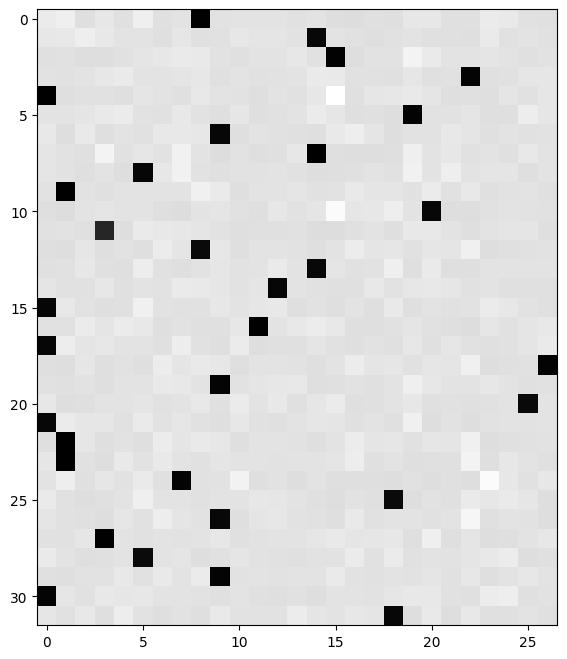

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray');

## Exercise 3 - Simplifying the BatchNorm

To complete this challenge look at the mathematical expression of the output of batchnorm,<br>
take the derivative w.r.t. its input, simplify the expression, and just write it out.<br><br>
BatchNorm paper: [\[Ioffe, Sergey; Szegedy, Christian. 2015\]](https://arxiv.org/abs/1502.03167).

We want to find one single operation to backprop through the entire stack of equations making up BatchNorm.<br>
We have `dhpreact` ($y_i$ in the paper) and want to produce `dhprebn` from it efficiently.

In [34]:
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


Let's just write out the equations from the BatchNorm paper:
$$\mu_B = \frac{1}{m} \sum_{i=1}^m x_i\\
\sigma_B^2 = \frac{1}{m-1} \sum_{i=1}^m(x_i-\mu_B)^2\ \ \ \ \ \small{(\text{Bessel-corrected})}\\
\hat{x_i} = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2+\epsilon}}\\
y_i = \gamma\hat{x_i}+\beta \equiv BN_{\gamma,\beta}(x_i)$$
We have $\frac{\partial l}{\partial y_i}$, and based on that, we want $\frac{\partial l}{\partial x_i}$.

### Step 1

The first part is straight-forward.<br>
For $y_i = \gamma\hat{x_i}+\beta$, we can derive $\frac{\partial l}{\partial \hat{x_i}} = \frac{\partial l}{\partial y_i} \cdot \gamma$.


### Step 2

For $\frac{\partial l}{\partial \sigma^2}$, we have to consider that there exist many $\hat{x_i}$ within $\hat{x}$.<br>
Each of these individual values depend on $\sigma^2$ for themselves. "There's lots of arrows from $\sigma^2$ pointing at $\hat{x}$."

This is why we need to sum over all the $i$ for the $\hat{x_i}$.

$$\frac{\partial l}{\partial \sigma^2} = \sum_{i}\left( \frac{\partial l}{\partial \hat{x_i}} \cdot \frac{\partial \hat{x_i}}{\partial \sigma^2}\right) $$

Working this expression out, we get:

$$= \gamma \cdot \sum_i \frac{\partial}{\partial \sigma^2}\begin{bmatrix}(x_i - \mu)(\sigma^2 + \epsilon)^{-1/2}\end{bmatrix} \cdot \frac{\partial l}{\partial y_i}\\
= \frac{1}{2} \gamma \sum_i (x_i - \mu)(\sigma^2+\epsilon)^{-3/2} \cdot \frac{\partial l}{\partial y_i}$$


### Step 3

What is $\frac{\partial l}{\partial \mu}$?<br>
The relationship between $\mu$ and $\hat{x}$ is $32$-fold (just like between $\sigma^2$ and $\hat{x}$ prior).<br>
The relationship between $\mu$ and $\sigma^2$ is $1$-fold, as $\sigma^2$ is just a scalar (see above).

All these $33$ incoming gradients need to be summed up within $\mu$.

$$\frac{\partial l}{\partial \mu} = \sum_i \left( \frac{\partial l}{\partial \hat{x}} \cdot \frac{\partial \hat{x_i}}{\partial \sigma^2}\right) + \left( \frac{\partial l}{\partial \sigma^2} \cdot \frac{\partial \sigma^2}{\partial \mu}\right)$$

The first part is the $32$-fold relationship. The added, second part is the $1$-fold relationship.

### Step 4

Now, for each $x_i$ in $x$, three arrows emanate:
- an arrow towards $\mu$
- an arrow towards $\sigma^2$
- an arrow towards *each individual* $\hat{x_i}$ in $\hat{x}$

In [35]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# Getting this python code for the above final equation is not easy
dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():
  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, dim=1) # Softmax along the rows of logits
    dlogits[range(n), Yb] -= 1 # At the correct position(s) within dlogits, we need to always subtract a 1
    dlogits /= n               # Scale down gradient by n because of the mean
    # 2nd Linear Layer
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # Tanh
    dhpreact = (1.0 - h**2) * dh
    # Batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st Linear Layer
    dembcat = dhprebn @ W1.T
    dW1 = dembcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # Embedding Layer
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # Comment out early breaking below when ready to train full net
    # if i >= 100:
    #   break

12297
      0/ 200000: 3.7918
  10000/ 200000: 2.2118
  20000/ 200000: 2.4945
  30000/ 200000: 2.7126
  40000/ 200000: 2.1289
  50000/ 200000: 2.8434
  60000/ 200000: 2.5684
  70000/ 200000: 2.3247
  80000/ 200000: 2.5403
  90000/ 200000: 2.4744
 100000/ 200000: 2.7280
 110000/ 200000: 3.0945
 120000/ 200000: 2.7420
 130000/ 200000: 2.8820
 140000/ 200000: 2.8666
 150000/ 200000: 2.8361
 160000/ 200000: 2.8772
 170000/ 200000: 2.6707
 180000/ 200000: 2.7903
 190000/ 200000: 2.8445


In [41]:
# useful for checking your gradients

# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [42]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [43]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.8233625888824463
val 2.8218600749969482


In [51]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

ernaaimyaahreelmnd.
ryalaretmrsjejdrleg.
adeeedieliihemy.
realekeiseananarneatzimhlkaa.
n.
sadbvrgahimies.
.
n.
jr.
eelklxnteuoanu.
amnedar.
yirle.
ehs.
laajaysknyaaahya.
nalyaisun.
zajelveuren.
.
.
t.
nsveaoec.


<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>